# File to compute filtering and observations extracting from MITgcm 

In [ ]:
ask_workers = 24

from dask.distributed import Client, LocalCluster
#cluster = LocalCluster(n_workers=ask_workers,dashboard_address=':8686')
cluster = LocalCluster()
c = Client(cluster)
c

In [ ]:
#cluster.close()

In [2]:
import os

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xskillscore
from scipy.interpolate import griddata
from scipy import signal

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

import scipy.fftpack as fp

from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans

from dask import delayed,compute

import glob

import gc

import pyinterp.backends.xarray
# Module that handles the filling of undefined values.
import pyinterp.fill

## 1 - Removing DAC 

### 1.1 - Removing DAC from raw SSH 

DAC (Dynamic Atmospheric Correction) aims at correcting ocean dynamic response to pressure forcing at high frequencies. This high frequency variability needs to be corrected from independent model. DAC is calculated from Mog2D (2 Dimensions Gravity Waves model) model on a 1/4° regular grid. In this part, DAC signal is removed from MITgcm SSH raw fields. Files are opened one by one from **"/bettik/bellemva/MITgcm/MITgcm_raw/"**, and DAC information contained in **"/bettik/bellemva/MITgcm/MITgcm_dac/"** is removed. File is then saved in **"/bettik/bellemva/MITgcm/MITgcm_filtered/"**, which will contain filtered SSH field files. 

In [ ]:
# date array
date = np.arange(np.datetime64("2012-04-01"),np.datetime64("2012-10-31"))
#date = np.arange(np.datetime64("2012-06-10"),np.datetime64("2012-06-11"))

# bathymetry map to define ocean pixels 
bathymetry = xr.open_dataset("/bettik/bellemva/sad/Bathy_1_30.nc")
bathymetry = bathymetry.interp({"NbLongitudes" : np.arange(180,245.01,1/48), "NbLatitudes" : np.arange(10,45.01,1/48)},method='nearest')

# mask of ocean (dim : (24,lat,lon)) 
#   - True : ocean 
#   - False : coast 
mask_ocean = bathymetry.Grid_0001.values<0
mask_ocean = np.repeat(mask_ocean[np.newaxis,:,:],24,axis=0).transpose([0,2,1])


for d in date : 
    # ds_ssh : dataset of raw MITgcm ssh 
    ds_ssh = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_raw/MITgcm_17280_lev_"+d.astype('str').replace("-","")+".nc") # opening raw MITgcm file
    time_array=np.arange(np.datetime64(d.astype('str')+"T00:00:00.000000000"),np.datetime64((d+np.timedelta64(1,"D")).astype('str')+"T00:00:00.000000000"),np.timedelta64(1,"h"))
    ds_ssh["time"]=time_array
    #ds_ssh_bis = ds_ssh.interp(time=time_array,method='linear') # this line was used before bit it created NaNs at time 23:00:00
    

    # ocean mask to put nan on continent
    ds_ssh["mask_ocean"] = xr.DataArray(data=mask_ocean,coords={"time" : time_array, "latitude" : ds_ssh.latitude.values,"longitude" : ds_ssh.longitude.values}) 

    # ds_dac : dataset of MITgcm DAC
    ds_dac = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_dac/llc4320_"+d.astype('str').replace("-","")+".nc")
    ds_dac = ds_dac.interp({"longitude" : ds_ssh.longitude.values, "latitude" : ds_ssh.latitude.values},method = "nearest")

    # "ssh_dedac" is the attribute representing SSH after substracting DAC  
    ds_ssh["ssh_dedac"] = (ds_ssh["lev"] - ds_dac["dac"])
    ds_ssh["ssh_dedac"] = xr.where(cond = ds_ssh["mask_ocean"],x = ds_ssh["ssh_dedac"],y = np.nan)
    ds_ssh = ds_ssh.drop_vars(["lev","mask_ocean"])

    ds_ssh.ssh_dedac.attrs['title'] = "ssh_dedac"
    ds_ssh.ssh_dedac.attrs['summary'] = "Sea Surface Height (SSH) after substracting Dynamic Atmospheric Correction (DAC)"
    ds_ssh.ssh_dedac.attrs['unit'] = "m"

    # dataset with "ssh_dedac" is saved in the MITgcm_filtered directory 
    ds_ssh.to_netcdf("/bettik/bellemva/MITgcm/MITgcm_dedac/"+"MITgcm_"+d.astype('str').replace("-","")+".nc")

    print(d)
    


### 1.2 - Checking signal variance diminution

In order to confirm that Dynamic Atmospheric Correction (DAC) removed an unwanted part of the ocean dynamics, it is necessary to check that removing DAC decreased ocean temporal variability. To do so, temporal variance of raw ssh is calculated, as well as temporal variability of ssh without DAC signal. Both variance are compared in the diff map (last cell) to be sure that ocean variability decreased when DAC was removed. 

This dataset contains the MITgcm raw SSH : 

In [ ]:
ssh = xr.open_mfdataset("/bettik/bellemva/MITgcm/MITgcm_raw/*.nc",combine="nested",concat_dim="time")
ssh = ssh.interp(time=np.arange(np.datetime64("2012-04-01T00:00:00.000000000"),np.datetime64("2012-10-31T00:00:00.000000000"),np.timedelta64(1,"h"))) # interpolating time coordinate on hourly spaced grid
ssh

This dataset contains the Dynamic Atmospheric Correction (DAC) : 

In [ ]:
# Dataset of MITgcm ssh 

def get_path(date):
    return "/bettik/bellemva/MITgcm/MITgcm_dac/llc4320_"+date.astype('str').replace("-","")+".nc"

day_array1 = np.arange(np.datetime64("2012-04-01"),np.datetime64("2012-08-01"))
day_array2 = np.arange(np.datetime64("2012-08-02"),np.datetime64("2012-10-31"))

day_array1 = list(map(get_path,day_array1))
day_array2 = list(map(get_path,day_array2))

dac = xr.concat([xr.open_mfdataset(day_array1,combine="nested",concat_dim="time"),
                 xr.open_mfdataset(day_array2,combine="nested",concat_dim="time")],dim="time")

The attribute "ssh_dedac" contains the SSH signal, when DAC has been removed. 

In [ ]:
# dedac ssh attribute ["ssh_dedac"]

ssh["ssh_dedac"] = ssh["lev"]-dac.interp({"longitude" : ssh.longitude.values, "latitude" : ssh.latitude.values},method = "nearest")["dac"]

This cell computes the variance of ssh raw signal (**variance_ssh**), the variance of ssh signal with DAC removed (**variance_dedac**) and calculated the difference of both (**diff**). Please note that the variable **diff** has been saved and is loaded for quicker computation. 

In [ ]:
variance_ssh = ssh.lev.var(dim="time")
variance_ssh = variance_ssh.compute()

variance_dedac = ssh.ssh_dedac.var(dim="time")
variance_dedac = variance_dedac.compute()


In [ ]:
#diff = variance_ssh.values - variance_dedac.values
diff = np.load("/bettik/bellemva/MITgcm/other/diff_ssh_dac.npy")

In [ ]:
longitude = np.arange(180,245.01,1/48)
latitude = np.arange(10,45.01,1/48)

fig, ax = plt.subplots(figsize=(9,4),dpi=200,subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0.)})

ax.set_extent([-180, -115,10, 45],crs=ccrs.PlateCarree())
map_diff = ax.pcolormesh(longitude,
              latitude,
              diff*10000,
              vmin=-100,vmax = 100,
              cmap="bwr"
              )

ax.add_feature(cfeature.LAND,color="lightgrey",zorder=1)
ax.add_feature(cfeature.OCEAN,color="black",zorder=0)
ax.coastlines(lw=0.5)
ax.set_aspect("equal")
ax.set_title("SSH variance difference when removing DAC")

gridlines = ax.gridlines(
    alpha=0.3,
    color="white",
    draw_labels=True,
    xlocs=np.arange(-180,-115,10),
    ylocs=np.arange(10,45,5),
    # xformatter=cartopy.mpl.ticker.LongitudeFormatter(zero_direction_label=True,),
)
gridlines.right_labels = False
gridlines.top_labels  = False
gridlines.xlabel_style = {'size': 11}
gridlines.ylabel_style = {'size': 11}
ax.set_aspect("equal")

cbar = plt.colorbar(mappable = map_diff,shrink = 0.95)
cbar.set_label("Variance difference [cm2]")

## 2. - Extracting BM and HF signal 

### 2.1 - Load SSH data 

In [ ]:
dir_input = '/bettik/bellemva/MITgcm/MITgcm_dedac'
pattern = 'MITgcm_'

In [ ]:
ds_ssh = xr.open_mfdataset(os.path.join(dir_input,pattern+'*.nc'))#.sel(time=slice(np.datetime64("2012-04-01T00:00:00.000000000"),np.datetime64("2012-06-30T23:00:00.000000000")))
#ds_ssh = ds_ssh.sel(longitude=slice(210,215),latitude=slice(25,30),time=slice(np.datetime64("2012-04-01T00:00:00.000000000"),np.datetime64("2012-06-30T23:00:00.000000000")))
ds_ssh

In [ ]:
ds_ssh = ds_ssh.chunk({'longitude':5,'latitude':5,'time':ds_ssh.time.size})

In [ ]:
ds_ssh

### 2.2 - Process parameters 

In [ ]:
longitude = ds_ssh.longitude.values
latitude = ds_ssh.latitude.values
time = ds_ssh.time.values
nt = time.size
ny = latitude.size
nx = longitude.size

This cell calculates the Coriolis frequency and period : 

In [ ]:
# Coriolis period
f = 2*2*np.pi/86164*np.sin(np.mean(np.deg2rad(latitude))) 
T = 2*np.pi/f
print("Coriolis period in hours :",T//3600)

This cell computes the Gaussian Kernel for a low pass filter at a cutting frequency of the Coriolis period. 

In [ ]:
dt = 3600 # number of seconds in a hour 
window_len = int(2*T//dt) # length of the gaussian filter window 
time_window = np.arange(-window_len,window_len+1) # array time steps to compute the kernel 
exp_window = np.exp(-np.square(time_window/(T/dt))) # array of kernel values 

plt.plot(time_window,exp_window)

ntw = time_window.size


### 2.3 - Filtering for BM extraction 

In [ ]:
weight = xr.DataArray(exp_window, dims=['window'])
ssh_dedac = ds_ssh.ssh_dedac.chunk({'longitude':5*48,'latitude':5*48,'time':ds_ssh.time.size})#[:nt-nt%ntw]
ssh_bm = ssh_dedac.rolling(time=ntw, center=True).construct('window').dot(weight)/weight.sum()
ssh_bm = ssh_bm.chunk({'longitude':5*48,'latitude':5*48,'time':-1})
ssh_bm

In [ ]:
ssh_hf = ssh_dedac - ssh_bm
ssh_hf = ssh_hf.chunk({'longitude':5*48,'latitude':5*48,'time':ds_ssh.time.size})
ssh_hf

In [ ]:
_ssh_bm = ssh_bm.sel(longitude=200,latitude =20).load()
_ssh_bm

In [ ]:
_ssh_bm[1556]

In [ ]:
_ssh_dedac = ssh_dedac.sel(longitude=200,latitude =20)

In [ ]:
def save_bm_hf(_ssh_dedac,_ssh_bm,dir_output):
    _ssh_bm = _ssh_bm.load()
    _ssh_hf = _ssh_dedac - _ssh_bm

    dsout = xr.Dataset({'ssh_dedac':(('time','latitude','longitude'),_ssh_dedac.data),
                    'ssh_bm':(('time','latitude','longitude'),_ssh_bm.data),
                    'ssh_hf':(('time','latitude','longitude'),_ssh_hf.data)
                    },
                    coords={'time':('time',_ssh_dedac.time.values),'latitude':('latitude',_ssh_dedac.latitude.values),'longitude':('longitude',_ssh_dedac.longitude.values)}
                    )

    name_file = "MITgcm_filt_"+str(_ssh_dedac.latitude.values[0])+"_"+str(_ssh_dedac.longitude.values[0])+".nc"

    #dsout.to_netcdf(os.path.join(dir_output,name_file))

    del _ssh_dedac, _ssh_bm 
    gc.collect()

In [ ]:
dir_output = "/bettik/bellemva/MITgcm/MITgcm_filtered"


In [ ]:
save_bm_hf(ssh_dedac.sel(latitude = slice(10,12),longitude = slice(180,182)),
               ssh_bm.sel(latitude = slice(10,12),longitude = slice(180,182)),
               dir_output)

In [ ]:
new_file = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered/MITgcm_filt_10.0_180.0.nc")

In [ ]:
new_file

In [ ]:
new_file.ssh_bm[51].plot()

In [ ]:
delayed_results = []
for i in range(2):
    for j in range (2) : 
        res = delayed(save_bm_hf)(x[i],y[j])
        delayed_results.append(res)
results = compute(*delayed_results, scheduler="processes")

In [ ]:
ssh_bm = ssh_bm.load()

### 2.3 - Concatenating spatial patches

This variable contains all values of bm, hf and dedac ssh fields. yet, it is a very huge dataset in memory (500 Gb)

In [ ]:
ds = xr.open_mfdataset("/bettik/bellemva/MITgcm/MITgcm_filtered/MITgcm_filt_*.nc",parallel=True)
ds = ds.chunk({'longitude':-1,'latitude':-1,'time':24}) #rechucking the dataset 
#ds = ds.load()

This function aims at opening an concatenating files of 5°x5°

In [ ]:
def open_concatenate(lat_min,lat_max,lon_min,lon_max):
    ds = xr.open_mfdataset(["/bettik/bellemva/MITgcm/MITgcm_filtered_bis/MITgcm_filt_"+str(lat_min)+"_"+str(lon_min)+".nc",
                            "/bettik/bellemva/MITgcm/MITgcm_filtered_bis/MITgcm_filt_"+str(lat_min)+"_"+str(lon_max)+".nc",
                            "/bettik/bellemva/MITgcm/MITgcm_filtered_bis/MITgcm_filt_"+str(lat_max)+"_"+str(lon_min)+".nc",
                            "/bettik/bellemva/MITgcm/MITgcm_filtered_bis/MITgcm_filt_"+str(lat_max)+"_"+str(lon_max)+".nc"],parallel=True)
    ds = ds.load()
    ds.to_netcdf("/bettik/bellemva/MITgcm/MITgcm_filtered_second/MITgcm_filt_"+str(lat_min)+"_"+str(lon_min)+".nc")
    del ds

    

In [ ]:
for lat_min in [10.0]:
    for lon_min in [220.0]: 
        open_concatenate(lat_min,lat_min+10.0,lon_min,lon_min+10.0)
        print(lat_min," ; ",lon_min)

This variable contains all the 10°x10° patches of filtered SSH. 

In [ ]:
ds = xr.open_mfdataset("/bettik/bellemva/MITgcm/MITgcm_filtered_bis/MITgcm_filt_30.0*.nc",parallel=True)
ds = ds.load()
ds.to_netcdf("/bettik/bellemva/MITgcm/MITgcm_filtered_second/MITgcm_filt_30.0.nc")

This cell belows concatenate different patches : 

In [ ]:
ds = xr.open_mfdataset(["/bettik/bellemva/MITgcm/MITgcm_filtered/MITgcm_filt_10.0_180.0.nc",
                        "/bettik/bellemva/MITgcm/MITgcm_filtered/MITgcm_filt_10.0_185.0.nc",
                        "/bettik/bellemva/MITgcm/MITgcm_filtered/MITgcm_filt_15.0_180.0.nc",
                        "/bettik/bellemva/MITgcm/MITgcm_filtered/MITgcm_filt_15.0_185.0.nc"],parallel=True)
ds = ds.chunk({'longitude':-1,'latitude':-1,'time':24}) #rechucking the dataset
ds = ds.load()

This cell is for upper banner at 40° latitude :

In [ ]:
file_array = glob.glob("/bettik/bellemva/MITgcm/MITgcm_filtered/MITgcm_filt_40.0*.nc")
file_array.sort()
file_array = file_array[5:-1]
ds_up = xr.open_mfdataset(file_array,parallel=True)


In [ ]:
ds_up

In [ ]:
ds_up.to_netcdf("/bettik/bellemva/MITgcm/MITgcm_filtered_second/MITgcm_filt_40.0_205.0.nc")

This cell is for right banner : 

In [ ]:
file_array = glob.glob("/bettik/bellemva/MITgcm/MITgcm_filtered/MITgcm_filt_*_240.0.nc")
file_array.sort()
#file_array = file_array[:-1]
ds_right = xr.open_mfdataset(file_array)

In [ ]:
ds_right.to_netcdf("/bettik/bellemva/MITgcm/MITgcm_filtered_second/MITgcm_filt_240.0.nc")

### 2.4 - Creating separate files for each date

In [ ]:
date = np.arange(np.datetime64("2012-04-01"),np.datetime64("2012-10-31"))

In [ ]:
date_str = date[0].astype('str').replace("-","")

In [ ]:
"/bettik/bellemva/MITgcm/MITgcm_filtered_second/split240.0/"+date_str+".nc"

In [ ]:
ds1 = xr.open_mfdataset(["/bettik/bellemva/MITgcm/MITgcm_filtered_second/split_10.0_180.0/20120501.nc",
                         "/bettik/bellemva/MITgcm/MITgcm_filtered_second/split_10.0_200.0/20120501.nc",
                         "/bettik/bellemva/MITgcm/MITgcm_filtered_second/split_10.0_220.0/20120501.nc"])

ds2 = xr.open_mfdataset(["/bettik/bellemva/MITgcm/MITgcm_filtered_second/split30.0_180.0/20120501.nc",
                         "/bettik/bellemva/MITgcm/MITgcm_filtered_second/split30.0_190.0/20120501.nc",
                         "/bettik/bellemva/MITgcm/MITgcm_filtered_second/split30.0_200.0/20120501.nc",
                         "/bettik/bellemva/MITgcm/MITgcm_filtered_second/split30.0_210.0/20120501.nc",
                         "/bettik/bellemva/MITgcm/MITgcm_filtered_second/split30.0_220.0/20120501.nc",
                         "/bettik/bellemva/MITgcm/MITgcm_filtered_second/split30.0_230.0/20120501.nc"])

ds3 = xr.open_mfdataset(["/bettik/bellemva/MITgcm/MITgcm_filtered_second/split40.0_180.0/20120501.nc",
                       "/bettik/bellemva/MITgcm/MITgcm_filtered_second/split40.0_205.0/20120501.nc"])

ds4 = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_second/split240.0/20120501.nc")


In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
ds_left = xr.concat([ds1.sel(latitude = slice(10,30-1/50)),
                    ds2.sel(latitude = slice(30,40-1/50)),
                    ds3],dim="latitude")
ds_left = ds_left.drop_duplicates(dim="latitude")
ds_left = ds_left.drop_duplicates(dim="longitude")
ds4 = ds4.drop_duplicates(dim="latitude")

ds = xr.concat([ds_left.sel(longitude = slice(180,240-1/50)),ds4],dim="longitude")
ds

In [ ]:
ds = ds.load()
#ds.ssh_hf[15].plot()

## 3. - Removing barotropic tide 

### 3.1 - Processing 

In [61]:
ds = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120606.nc")
ds = ds.sel(time = np.datetime64("2012-06-06T05"))
ds = ds.where(np.invert(mask))

rolling = ds.ssh_hf.rolling({'longitude':5,'latitude':5},center=True,min_periods=1).mean()
ds_deg = rolling.interp({'longitude':np.round(np.arange(180.0,245.0+1/13,1/12),decimals=10),'latitude':np.round(np.arange(10.0,45.0+1/13,1/12),decimals=10)})
ds_deg

<xarray.DataArray 'ssh_hf' (latitude: 421, longitude: 781)>
array([[ 0.70238286,  0.7028284 ,  0.70832717, ...,  0.33781097,
         0.34589509,  0.35826811],
       [ 0.71709595,  0.71723381,  0.72949092, ...,  0.35508166,
         0.34088846,  0.34803683],
       [ 0.72844826,  0.73404572,  0.74552861, ...,  0.3478978 ,
         0.34328112,  0.34728825],
       ...,
       [-0.30772731, -0.30874373, -0.30950425, ...,         nan,
                nan,         nan],
       [-0.30623956, -0.30740776, -0.30699761, ...,         nan,
                nan,         nan],
       [-0.30237395, -0.30101566, -0.30123863, ...,         nan,
                nan,         nan]])
Coordinates:
    time       datetime64[ns] 2012-06-06T05:00:00
  * longitude  (longitude) float64 180.0 180.1 180.2 180.2 ... 244.8 244.9 245.0
  * latitude   (latitude) float64 10.0 10.08 10.17 10.25 ... 44.83 44.92 45.0

In [62]:
longitude = ds_deg.longitude.values
latitude = ds_deg.latitude.values

x_axis = pyinterp.Axis(longitude)
y_axis = pyinterp.Axis(latitude)

time = ds_deg.time.values
nt = time.size
ny = latitude.size
nx = longitude.size

shapeout = (24,latitude.size,longitude.size)


In [63]:
def lonlat2dxdy(lon,lat):
    dlon = np.gradient(lon)
    dlat = np.gradient(lat)
    dx = np.sqrt((dlon[1]*111000*np.cos(np.deg2rad(lat)))**2
                 + (dlat[1]*111000)**2)
    dy = np.sqrt((dlon[0]*111000*np.cos(np.deg2rad(lat)))**2
                 + (dlat[0]*111000)**2)
    dx[0,:] = dx[1,:]
    dx[-1,: ]= dx[-2,:] 
    dx[:,0] = dx[:,1]
    dx[:,-1] = dx[:,-2]
    dy[0,:] = dy[1,:]
    dy[-1,:] = dy[-2,:] 
    dy[:,0] = dy[:,1]
    dy[:,-1] = dy[:,-2]
    return dx,dy

In [64]:
def gaspari_cohn(r,c):
    """
    NAME 
        bfn_gaspari_cohn

    DESCRIPTION 
        Gaspari-Cohn function. Inspired from E.Cosmes.
        
        Args: 
            r : array of value whose the Gaspari-Cohn function will be applied
            c : Distance above which the return values are zeros


        Returns:  smoothed values 
            
    """ 
    if type(r) is float or type(r) is int:
        ra = np.array([r])
    else:
        ra = r
    if c<=0:
        return np.zeros_like(ra)
    else:
        ra = 2*np.abs(ra)/c
        gp = np.zeros_like(ra)
        i= np.where(ra<=1.)[0]
        gp[i]=-0.25*ra[i]**5+0.5*ra[i]**4+0.625*ra[i]**3-5./3.*ra[i]**2+1.
        i =np.where((ra>1.)*(ra<=2.))[0]
        gp[i] = 1./12.*ra[i]**5-0.5*ra[i]**4+0.625*ra[i]**3+5./3.*ra[i]**2-5.*ra[i]+4.-2./3./ra[i]
        if type(r) is float:
            gp = gp[0]
    return gp

In [65]:
lon2d,lat2d = np.meshgrid(longitude,latitude)
dx,dy = lonlat2dxdy(lon2d,lat2d)
dx0 = dx.mean()
dy0 = dy.mean()

kx = np.fft.fftfreq(3*nx,dx0*1e-3) # km
ky = np.fft.fftfreq(3*ny,dy0*1e-3) # km
k, l = np.meshgrid(kx,ky)
wavnum2D = np.sqrt(k**2 + l**2)

## Spatial window

winy = np.ones(3*ny)
winy[:ny] = gaspari_cohn(np.arange(0,ny,1),ny)[::-1]
winy[2*ny:] = gaspari_cohn(np.arange(0,ny),ny)

winx = np.ones(3*nx)
winx[:nx] = gaspari_cohn(np.arange(0,nx,1),nx)[::-1]
winx[2*nx:] = gaspari_cohn(np.arange(0,nx),nx)

window = winy[:,np.newaxis] * winx[np.newaxis,:]

kernel = Gaussian2DKernel(x_stddev=25)

In [66]:

def extend(ssh):
    ssh_extended = np.empty((3*ny,3*nx))
    ssh_extended[ny:2*ny,nx:2*nx] = +ssh
    ssh_extended[0:ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[2*ny:3*ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[:,0:nx] = ssh_extended[:,nx:2*nx][:,::-1]
    ssh_extended[:,2*nx:3*nx] = ssh_extended[:,nx:2*nx][:,::-1]
    return ssh_extended

def highpass(_lambda,nx,ny):
    _highpass = np.zeros((3*ny,3*nx))
    for i in range(3*ny):
        for j in range(3*nx):
            if wavnum2D[i,j]>1/_lambda:
                _highpass[i,j] = 1
    return _highpass

def lowpass(_lambda,nx,ny) : 
    _lowpass = np.zeros((3*ny,3*nx))
    for i in range (3*ny):
        for j in range(3*nx):
            if wavnum2D[i,j]<1/_lambda:
                _lowpass[i,j] = 1
    return _lowpass 

def apply_filter(ssh_freq,H):
    ssh_freq_filtered = H * ssh_freq
    ssh_filtered = np.real(fp.ifft2(ssh_freq_filtered))
    return ssh_filtered


def interpolate_nans(_ds):
    has_converged, filled = pyinterp.fill.gauss_seidel(_ds)
    if has_converged :
        return filled.T
    else : 
        "Pyinterp hasn't converged"
        raise Exception


lambda_bar = 600

highpass_IT = highpass(lambda_bar,nx,ny)
lowpass_BAR = lowpass(lambda_bar,nx,ny)

Filtering of the barotropic tide 

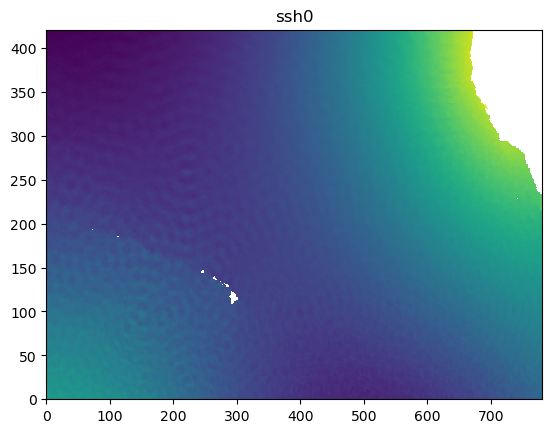

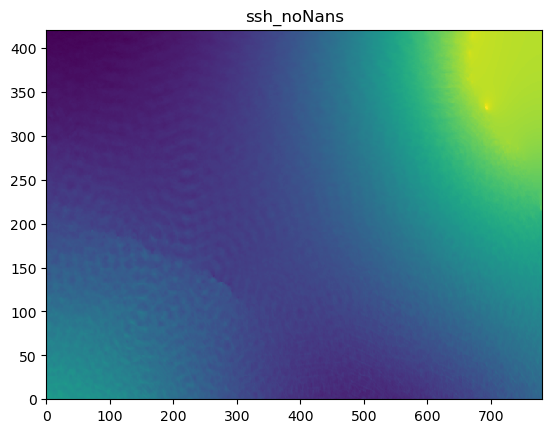

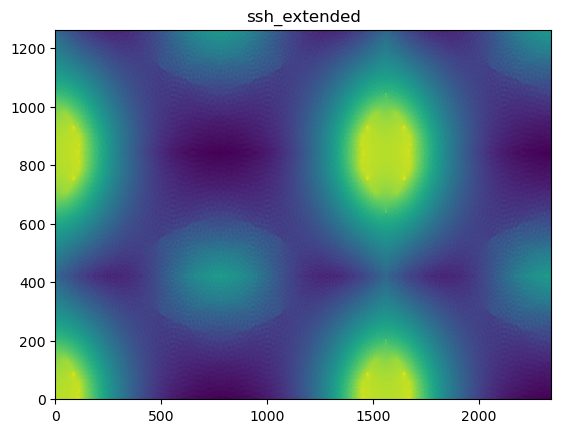

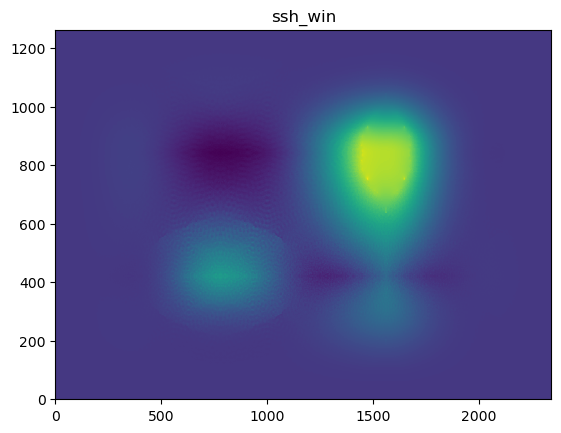

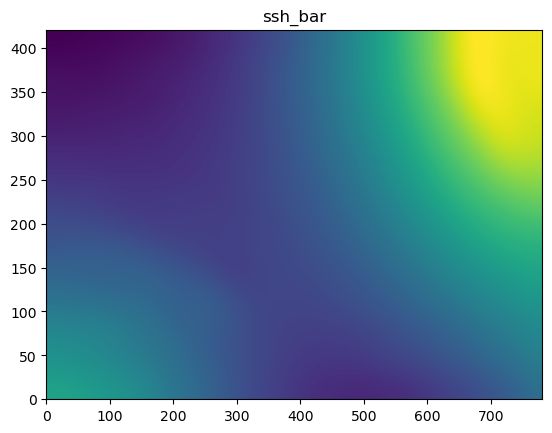

In [67]:

#i=0
plot=True

#for i in range(24):

#ssh0 = _ssh_hf[0].values
ssh0 = ds_deg.values
mask = np.isnan(ssh0)

if plot:
    plt.figure()
    plt.pcolormesh(ssh0)
    plt.title("ssh0")
    plt.show()

# Remove nans
ssh_noNans = interpolate_nans(pyinterp.Grid2D(x_axis, y_axis, ssh0.T))

if plot:
    plt.figure()
    plt.pcolormesh(ssh_noNans)
    plt.title("ssh_noNans")
    plt.show()

# Extend
ssh_extended = extend(ssh_noNans)

if plot:
    plt.figure()
    plt.pcolormesh(ssh_extended)
    plt.title("ssh_extended")
    plt.show()

    
# Windowing
ssh_win = ssh_extended * window

if plot:
    plt.figure()
    plt.pcolormesh(ssh_win)
    plt.title("ssh_win")
    plt.show()
    
# FFT
ssh_freq = fp.fft2(ssh_win)


# Filter
ssh_bar = apply_filter(ssh_freq, lowpass_BAR)[ny:2*ny,nx:2*nx]

if plot:
    plt.figure()
    plt.pcolormesh(ssh_bar)
    plt.title("ssh_bar")
    plt.show()

# Mask
ssh_bar[mask] = np.nan

    
# Fill array
#_ssh_bar[i] = ssh0 - ssh_igw
#_ssh_igw[i] = ssh_igw

    #print(i)
    
    
dsout = xr.Dataset({'ssh_bar':(('latitude','longitude'),ssh_bar.data),}, # don't forger to add 'time',
                    coords={'latitude':('latitude',latitude),'longitude':('longitude',longitude)} # don't forget to add 'time':('time',time),
                    )

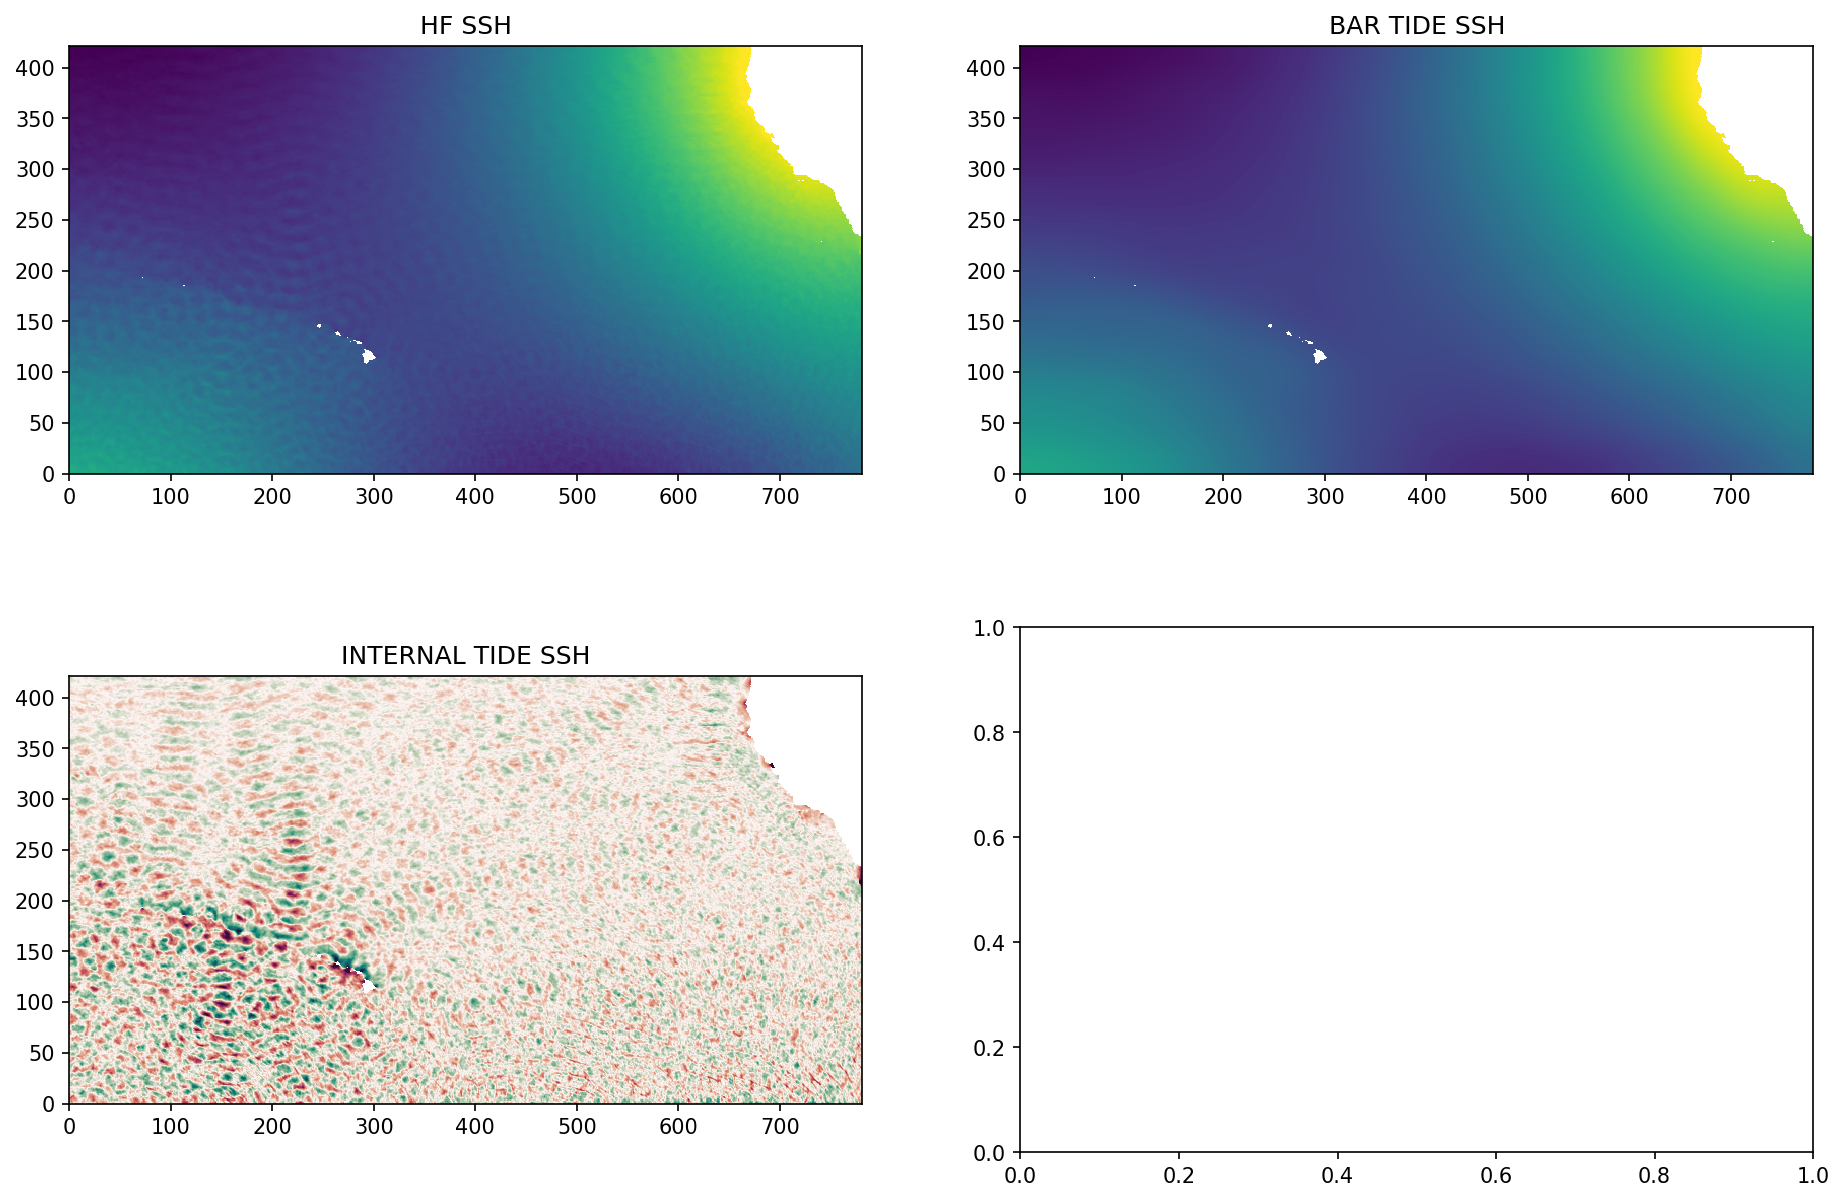

In [44]:
import cmocean

fig,axs = plt.subplots(2,2,figsize=(15,10),dpi=150)

plot_hf = axs[0,0].pcolormesh(ds_deg.values,vmin=-0.3,vmax=1.4)
axs[0,0].set_title("HF SSH")

plot_bar = axs[0,1].pcolormesh(ssh_bar,vmin=-0.3,vmax=1.4)
axs[0,1].set_title("BAR TIDE SSH")

plot_igw = axs[1,0].pcolormesh(ds_deg.values-ssh_bar,vmin=-0.1,vmax=0.1,cmap=cmocean.cm.curl)
axs[1,0].set_title("INTERNAL TIDE SSH")

axs[0,0].set_aspect("equal")
axs[0,1].set_aspect("equal")
axs[1,0].set_aspect("equal")




### 3.1 - Checking the dates for which barotropic tide haven't been calculated 

In [3]:
time_array = np.arange(np.datetime64("2012-06-01"),np.datetime64("2012-08-01"),np.timedelta64(1,("h")))

#time_array = np.array([np.datetime64("2012-04-20T12")])


In [4]:
missing_date_bis = []
#missing_date = np.load("./extract_bar_tide/lambda_bar_600/missing_date.npy")

for t in time_array : 
#for t in missing_date : 
    date_split = t.astype('str').split("T")
    date_str = date_split[0].replace("-","")+"T"+str(int(date_split[1]))
    try:
        data = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_bar/lambda_bar_600/MITgcm_bar_"+date_str+".nc")
    except FileNotFoundError:
        missing_date_bis.append(t)



In [5]:
len(missing_date_bis)

0

In [6]:
len(missing_date_bis)

0

In [7]:
missing_date_bis

[]

In [8]:
np.save("./extract_bar_tide/lambda_bar_600/missing_date.npy",np.array(missing_date_bis))

In [ ]:
missing_date_bis

## 4. - Masking of MITgcm data 

In [3]:
mask = np.load("/bettik/bellemva/MITgcm/mask/mask_MITgcm.npy")

In [5]:
ds_ssh = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120801.nc",
                         drop_variables=["ssh_bm","ssh_hf"])

In [13]:
ds_ssh

<xarray.Dataset>
Dimensions:    (latitude: 1681, longitude: 3121, time: 24)
Coordinates:
  * latitude   (latitude) float32 10.0 10.02 10.04 10.06 ... 44.96 44.98 45.0
  * longitude  (longitude) float32 180.0 180.0 180.0 180.1 ... 245.0 245.0 245.0
  * time       (time) datetime64[ns] 2012-08-01 ... 2012-08-01T23:00:00
Data variables:
    ssh_dedac  (time, latitude, longitude) float32 ...
Attributes:
    NCO:                        netCDF Operators version 4.9.8 (Homepage = ht...
    history_of_appended_files:  Thu Feb 16 20:02:06 2023: Appended file /bett...
    history:                    Fri Feb 24 16:07:59 2023: ncks -C -O -x -v ss...

In [11]:
mask_extended = np.expand_dims(mask,axis=0)
mask_extended = np.repeat(mask_extended,repeats = 24, axis = 0)

In [14]:
ds_mask = xr.DataArray(data = mask_extended,
                       dims = ["time","latitude","longitude"],
                       coords = dict(
                        time =(["time"],ds_ssh.time.values),
                        latitude = (["latitude"],ds_ssh.latitude.values),
                        longitude = (["longitude"],ds_ssh.longitude.values)
                       ))

In [16]:
ds_mask.to_netcdf("/bettik/bellemva/MITgcm/mask/mask.nc")

In [20]:
ds_ssh = ds_ssh.assign(mask = ds_mask)

In [26]:
ds_ssh.to_netcdf("/bettik/bellemva/MITgcm/mask/ds_ssh_test.nc")

In [27]:
ds_ssh_test = xr.open_dataset("/bettik/bellemva/MITgcm/mask/ds_ssh_test.nc")

(30.0, 40.0)

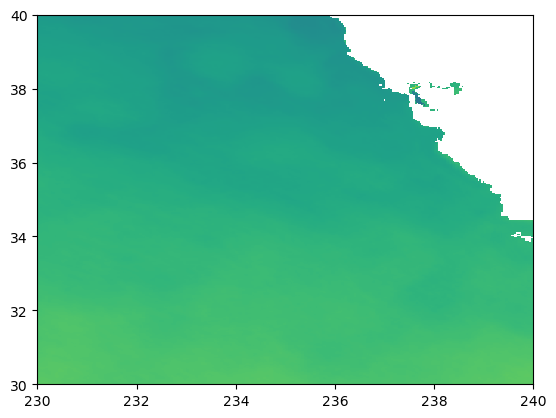

In [31]:
plt.pcolormesh(ds_ssh_test.longitude.values,ds_ssh_test.latitude.values,ds_ssh.ssh_dedac[12].values)
plt.xlim(230,240)
plt.ylim(30,40)

(30.0, 40.0)

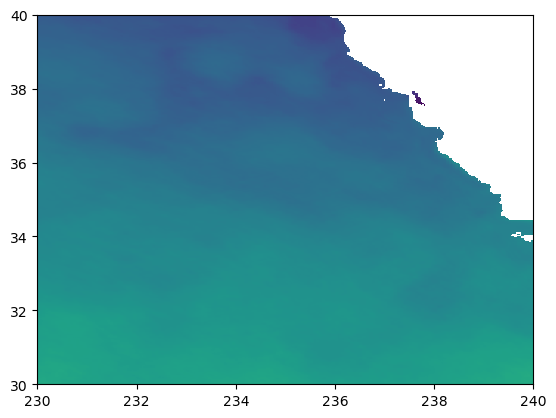

In [29]:
plt.pcolormesh(ds_ssh_test.longitude.values,ds_ssh_test.latitude.values,ds_ssh_test.ssh_dedac[12].values)
plt.xlim(230,240)
plt.ylim(30,40)

(30.0, 40.0)

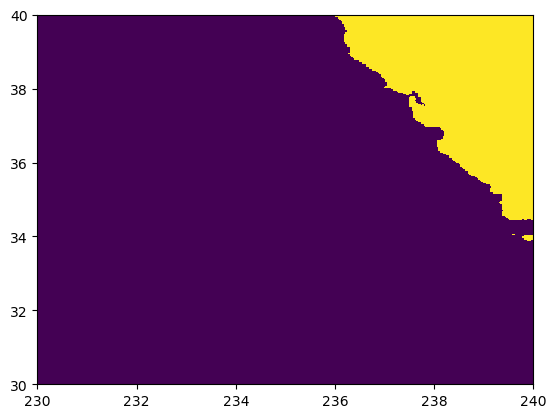

In [30]:
plt.pcolormesh(ds_ssh_test.longitude.values,ds_ssh_test.latitude.values,mask)
plt.xlim(230,240)
plt.ylim(30,40)

In [52]:
ds_ssh = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120701.nc")

mask = np.load("/bettik/bellemva/MITgcm/mask/mask_MITgcm.npy")
mask_extended = np.expand_dims(mask,axis=0)
mask_extended = np.repeat(mask_extended,repeats = 24, axis = 0)

x_axis = pyinterp.Axis(ds_ssh.longitude.values)
y_axis = pyinterp.Axis(ds_ssh.latitude.values)

shape_filled = (24, 3121, 1681)
filled_bm = np.empty(shape_filled)
filled_dedac = np.empty(shape_filled)
filled_hf = np.empty(shape_filled)
filled_bar = np.empty(shape_filled)

for i in range (24):
    has_converged, filled_bm[i,:,:] = pyinterp.fill.gauss_seidel(pyinterp.Grid2D(x_axis, y_axis, ds_ssh.ssh_bm[i].values.T))
    has_converged, filled_dedac[i,:,:] = pyinterp.fill.gauss_seidel(pyinterp.Grid2D(x_axis, y_axis, ds_ssh.ssh_dedac[i].values.T))
    has_converged, filled_hf[i,:,:] = pyinterp.fill.gauss_seidel(pyinterp.Grid2D(x_axis, y_axis, ds_ssh.ssh_hf[i].values.T))
    has_converged, filled_bar[i,:,:] = pyinterp.fill.gauss_seidel(pyinterp.Grid2D(x_axis, y_axis, ds_ssh.ssh_bar_600[i].values.T))


KeyboardInterrupt: 

In [48]:
filled_bm.shape

(3121, 1681)

In [34]:
ds_ssh = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120701.nc")

mask = np.load("/bettik/bellemva/MITgcm/mask/mask_MITgcm.npy")
mask_extended = np.expand_dims(mask,axis=0)
mask_extended = np.repeat(mask_extended,repeats = 24, axis = 0)

x_axis = pyinterp.Axis(ds_ssh.longitude.values)
y_axis = pyinterp.Axis(ds_ssh.latitude.values)

filled_bm = np.zeros_like(ds_ssh.ssh_bm.values.T)
filled_dedac = np.zeros_like(ds_ssh.ssh_dedac.values.T)
filled_hf = np.zeros_like(ds_ssh.ssh_hf.values.T)
filled_bar = np.zeros_like(ds_ssh.ssh_bar.values.T)


for i in range (24):
    has_converged, filled_bm[] = pyinterp.fill.gauss_seidel(pyinterp.Grid2D(x_axis, y_axis, ds_ssh.ssh_bm.values))
    has_converged, filled_dedac = pyinterp.fill.gauss_seidel(pyinterp.Grid2D(x_axis, y_axis, ds_ssh.ssh_dedac.values))
    has_converged, filled_hf = pyinterp.fill.gauss_seidel(pyinterp.Grid2D(x_axis, y_axis, ds_ssh.ssh_hf.values))
    has_converged, filled_bar = pyinterp.fill.gauss_seidel(pyinterp.Grid2D(x_axis, y_axis, ds_ssh.ssh_bar_600.values))

filled_bm = filled_bm.T[mask_extended] = np.nan
filled_dedac = filled_dedac.T[mask_extended] = np.nan
filled_hf = filled_hf.T[mask_extended] = np.nan
filled_bar = filled_bar.T[mask_extended] = np.nan

ds_bm = xr.DataArray(data = filled_bm,
                       dims = ["time","latitude","longitude"],
                       coords = dict(
                        time =(["time"],ds_ssh.time.values),
                        latitude = (["latitude"],ds_ssh.latitude.values),
                        longitude = (["longitude"],ds_ssh.longitude.values)
                       ))

ds_dedac = xr.DataArray(data = filled_dedac,
                       dims = ["time","latitude","longitude"],
                       coords = dict(
                        time =(["time"],ds_ssh.time.values),
                        latitude = (["latitude"],ds_ssh.latitude.values),
                        longitude = (["longitude"],ds_ssh.longitude.values)
                       ))

ds_hf = xr.DataArray(data = filled_hf,
                       dims = ["time","latitude","longitude"],
                       coords = dict(
                        time =(["time"],ds_ssh.time.values),
                        latitude = (["latitude"],ds_ssh.latitude.values),
                        longitude = (["longitude"],ds_ssh.longitude.values)
                       ))

ds_bar = xr.DataArray(data = filled_bar,
                       dims = ["time","latitude","longitude"],
                       coords = dict(
                        time =(["time"],ds_ssh.time.values),
                        latitude = (["latitude"],ds_ssh.latitude.values),
                        longitude = (["longitude"],ds_ssh.longitude.values)
                       ))

ds_ssh = ds_ssh.assign(ssh_bm = ds_bm)
ds_ssh = ds_ssh.assign(ssh_dedac = ds_dedac)
ds_ssh = ds_ssh.assign(ssh_hf = ds_hf)
ds_ssh = ds_ssh.assign(ssh_bar = ds_bar)

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. pyinterp.core.Axis(values: numpy.ndarray[numpy.float64], epsilon: float = 1e-06, is_circle: bool = False)

Invoked with: array(['2012-07-01T00:00:00.000000000', '2012-07-01T01:00:00.000000000',
       '2012-07-01T02:00:00.000000000', '2012-07-01T03:00:00.000000000',
       '2012-07-01T04:00:00.000000000', '2012-07-01T05:00:00.000000000',
       '2012-07-01T06:00:00.000000000', '2012-07-01T07:00:00.000000000',
       '2012-07-01T08:00:00.000000000', '2012-07-01T09:00:00.000000000',
       '2012-07-01T10:00:00.000000000', '2012-07-01T11:00:00.000000000',
       '2012-07-01T12:00:00.000000000', '2012-07-01T13:00:00.000000000',
       '2012-07-01T14:00:00.000000000', '2012-07-01T15:00:00.000000000',
       '2012-07-01T16:00:00.000000000', '2012-07-01T17:00:00.000000000',
       '2012-07-01T18:00:00.000000000', '2012-07-01T19:00:00.000000000',
       '2012-07-01T20:00:00.000000000', '2012-07-01T21:00:00.000000000',
       '2012-07-01T22:00:00.000000000', '2012-07-01T23:00:00.000000000'],
      dtype='datetime64[ns]')